In [5]:
import os
import math

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [6]:
# being extremely crude and naive here...
def dppgains(K, AA, aa, detKA):
    """ Returns det(K_{A+a}) - det(K_A)
    """
    Aa = np.append(AA,aa)
    KAa = np.atleast_2d(K[Aa])[:,Aa]
    return np.linalg.det(KAa) - detKA

In [7]:
def greedygains(V, X, k):
    """ Plots the submodular/log-submodular objective curve
        Over the addition of k items
    """
    
    [n,m] = X.shape
    if V == None:
        V = np.arange(n)
    
    K = X @ X.transpose()
    
    objs = np.empty(k+1)
    
    A = np.empty(0, int)
    ff = 1 # since this is a determinantal process and det(\phi) = 1
    objs[0] = ff
    
    for ii in range(k):
        
        maxgain = -100
        greedyv = np.random.choice(V)
        
        for vidx in range(len(V)):
            gain = dppgains(K, A, V[vidx], ff)
            if gain > maxgain:
                maxgain = gain
                greedyv = V[vidx]
        
        # add element to A, remove from V, update gains
        A = np.append(A, greedyv)
        V = V[V!=greedyv]
        ff += maxgain
        objs[ii+1] = ff
    
    return A, objs

In [40]:
def objplot(objs, ground):
    krange = np.arange(len(objs))
    
    plt.plot(krange, objs, "o", c="mediumvioletred", label="f(S)")
    #plt.plot(krange, [ground,]*len(objs), "--", c="maroon", label="ground set eval")
    plt.xlabel("set size")
    plt.legend(loc=2)
    

In [38]:
def logobjplot(objs, ground):
    krange = np.arange(len(objs))
    
    plt.plot(krange, np.log(objs), "o", c="purple", label="log(f(S))")
    plt.plot(krange, [np.log(ground),]*len(objs), "--", c="midnightblue", label="ground set eval")
    plt.xlabel("set size")
    plt.legend(loc=1)
    

In [3]:
n = 50
m = 200
k = 10

X = np.random.random((n, m))

K = X @ X.transpose()
ground = np.linalg.det(K)

In [8]:
S, objectives = greedygains(None, X, k)

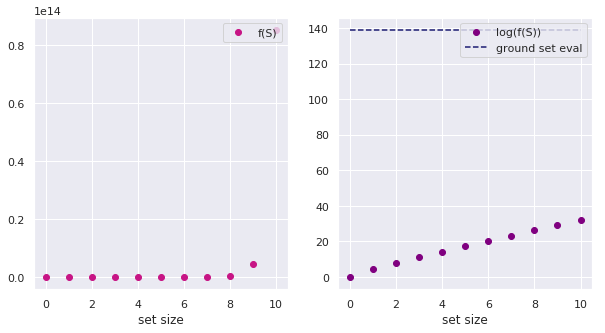

In [41]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
objplot(objectives, ground)
plt.subplot(1,2,2)
logobjplot(objectives, ground)

In [89]:
np.exp(objs)

array([2.71828183e+00, 2.27966387e+32,            inf,            inf,
                  inf,            inf,            inf,            inf,
                  inf,            inf,            inf])

In [90]:
### TODO:
"""
Add the normalizer everywhere
And then see the plot
"""

'\nAdd the normalizer everywhere\nAnd then see the plot\n'